In [1]:
# import packages
from math import sqrt,ceil,floor
import math
# import trackpy as tp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import interpolate
plt.rc('text', usetex=True)
from numba import jit,prange
# import numba
from scipy.stats import gaussian_kde,norm
from scipy.interpolate import splev, splrep
from scipy.optimize import curve_fit
import time
import datetime
import os
import glob
from tqdm import tqdm

# for list slicing.
from operator import itemgetter

import cv2 #package for image analysis
from scipy import spatial # for KD tree


plt.rcParams['font.size']=20
plt.rcParams["font.family"] = "Times New Roman"


from IPython.display import Latex
from IPython.display import Markdown

In [2]:
# subFolder='SimulationsNoTorqueWCA' # sym, epsilon 10**(-20)
# subFolder='SimulationsNoTorqueSYM_WCA' # epsilon 10**(-15)
# subFolder='SimulationsNoTorqueASYM_WCA'
# subFolder='SimulationsWithTorqueNoInt'
# subFolder='SimulationsWithTorquePPInt'
# subFolder='SimulationsWithTorqueNoIntSym'
# subFolder='SimulationsNoTorqueNoIntWCA'
# subFolder='SimulationWeakTorqueSymPPint'
# subFolder='SimulC1p1TorqueExptPrflNoPPint'
# subFolder='Simul_20190212_dblLineAsym2'
# subFolder='Simul_20190212_dblLineAsym2_drag2'
# subFolder='Simul_n4_20190114_S25_dilute_WrongPassiveVoltage' # ran with the 20190214_dblLineAsym\DEP20X1p5X_S25_2TMA_0H2O2_0p64pp_flippedDevice_007_EnergyForceProfiles.csv
# subFolder='CheckPressureTheoryNewFunctionExpt' # ran with the 20190214_dblLineAsym\DEP20X1p5X_S25_2TMA_0H2O2_0p64pp_flippedDevice_007_EnergyForceProfiles.csv
# subFolder='Simul_20190212_dblLineAsym2_n4'

# subFolder='ExtremeAsymBiharmonic' 
subFolder='20190212_dblLineAsym2/With008CalibDragMult2' # agrees with theory P, as long as low persistence length compared to bulk
# subFolder='ThermalLimitBiHarmonic'
# subFolder='ThermalLimitBiHarmonicSym2'

# subFolder='ExtremeAsymHarmonicAgain2'

CurrentFolder=os.getcwd()
CurrentFolder=CurrentFolder.replace('\\',r'/')+'/'+subFolder

In [3]:
CurrentFolder

'C:/Users/M/PycharmProjects/Simulation/20190212_dblLineAsym2/With008CalibDragMult2'

In [4]:
print(CurrentFolder)
filelistMeta=glob.glob(CurrentFolder+'/*MetaData.csv')
filelistPDF=glob.glob(CurrentFolder+'/*PDfunc.csv')
DataSummary=pd.DataFrame()
for filename in filelistMeta:
    DataSummary=DataSummary.append(pd.read_csv(filename,index_col=False))
print('Voltages:', np.sort(pd.unique(DataSummary['ActiveVoltage'])))
print('Velocities:',np.sort(pd.unique(DataSummary['velocity_umPs'])))
print('D_R:',np.sort(pd.unique(DataSummary['D_R_Ps'])))
print('Number Of particles:',np.sort(pd.unique(DataSummary['NumberOfParticles'])))
print('Drag multipliers', np.sort(pd.unique(DataSummary['drag_multiplier'])))
print('Torque ratio C', np.sort(pd.unique(DataSummary['C_ratio_dlctrc_cnst'])))

C:/Users/M/PycharmProjects/Simulation/20190212_dblLineAsym2/With008CalibDragMult2
Voltages: [10.2 11.  12. ]
Velocities: [0.  1.1 1.7 2.9 3.2 3.6]
D_R: [0.05       0.06666667 0.08333333 0.1        0.125     ]
Number Of particles: [  1 100]
Drag multipliers [2]
Torque ratio C [0.009 1.    1.001 1.002 1.003 1.005]


## Plots: general

In [5]:
# ADd feature to sum pressure only on last frames, using coords. 
PlotVariables=['ActiveVoltage', 'velocity_umPs', 'D_R_Ps', 'NumberOfParticles', 'C_ratio_dlctrc_cnst', 'drag_multiplier']
VariableStrings=['$V$ [V]', '$v$ [$\mu$m/$s$]','D_{\mathrm{R}}', '\# particles', 'C ratio','drag_multiplier']
indsToConstantVariables=(0,4,2,5, 3); 
ValuesOfConstantVariables=[10.2,1,1/10,2, 100]
# ValuesOfConstantVariables=[12,1,1/10,2]
# ValuesOfConstantVariables=[11.5,1,1/8,2]
# ValuesOfConstantVariables=[12,1,1/8,2]

MaximalVelocity = 4
# ChosenVelocities=[3.7, 3.2, 2.9, 1.7, 1.5, 1.1]
PlotTheory=True
ForceProbCenter=True
XlimForDensityPlot=(0,100)
ind_to_X_axis=1
ind_to_legend=1 # legend of the density plot. 

Total points after velocity filter 195
104 ActiveVoltage 10.2
41 C_ratio_dlctrc_cnst 1
21 D_R_Ps 0.1
21 drag_multiplier 2
11 NumberOfParticles 100


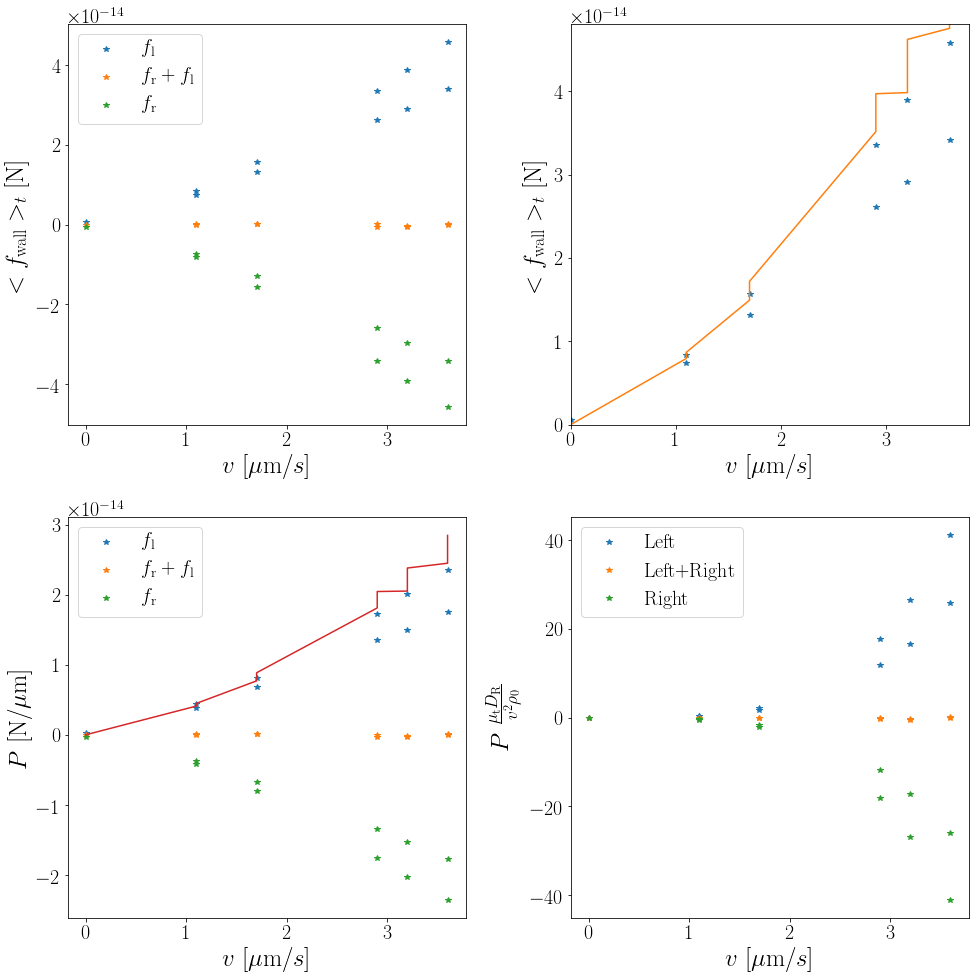

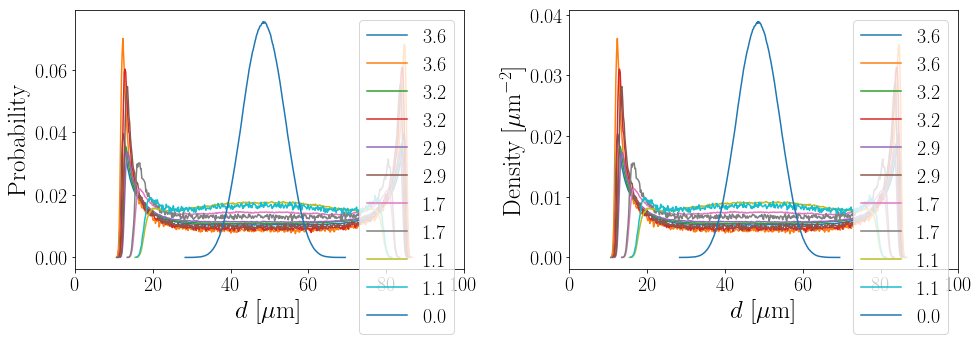

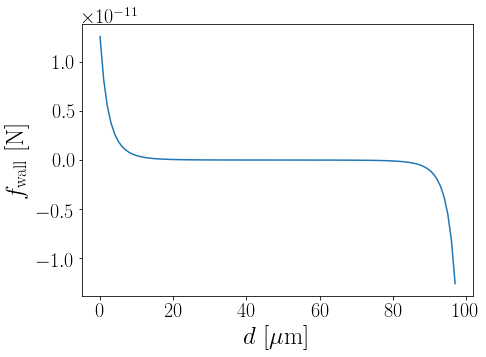

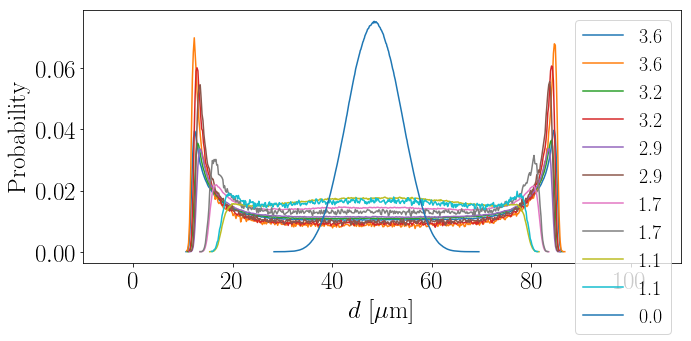

In [6]:
# all plots
if 1: # filter results
    ConstantVariableNames=itemgetter(*indsToConstantVariables)(PlotVariables)
    DFforPlot=DataSummary.copy()
    DFforPlot=DFforPlot.loc[DFforPlot['velocity_umPs']<MaximalVelocity] 
    print('Total points after velocity filter', len(DFforPlot))
    for ConstantVariableName,ValueOfConstantVariable in zip(ConstantVariableNames,ValuesOfConstantVariables):
        if ConstantVariableName in DFforPlot.columns:
            DFforPlot=DFforPlot.loc[np.abs((DFforPlot[ConstantVariableName]-ValueOfConstantVariable))<np.abs(ValueOfConstantVariable/1000)]
            print(len(DFforPlot), ConstantVariableName, ValueOfConstantVariable)
    # sorting by legend index
    DFforPlot=DFforPlot.sort_values(PlotVariables[ind_to_legend], ascending = False)
    # Use arrays for plots
    X_axis=DFforPlot[PlotVariables[ind_to_X_axis]]
    HalfAdd=str()
    if 'AverageForceLeft_N_lastHalf' in DFforPlot.columns:
        HalfAdd='_lastHalf'
    plotLeftForce  = DFforPlot['AverageForceLeft_N'+HalfAdd].values;
    plotRightForce = DFforPlot['AverageForceRight_N'+HalfAdd].values;
    plotSumForce   = DFforPlot['SumAverageForce_N'+HalfAdd].values;
    plotLeftP  = DFforPlot['PressureLeft_NPum'+HalfAdd].values;
    plotRightP = DFforPlot['PressureRight_NPum'+HalfAdd].values;
    plotSumP   = DFforPlot['SumPressure_NPum'+HalfAdd].values;
    mobilities=1/DFforPlot['drag_N_sPum'].values;
    ProbsAtCenter=DFforPlot['ProbAtCenter']
    ForcedDensityAtCneter=list()
    NumberOfParticlesArray=DFforPlot['NumberOfParticles']
    plt.rcParams['font.size']=20
    fig1, ax1=plt.subplots(2,2, figsize=([14,14])) 
if 1: # Plots: forces    
    ax1[0,0].plot(X_axis,plotLeftForce, '*')
    ax1[0,0].plot(X_axis,plotSumForce, '*')
    ax1[0,0].plot(X_axis,plotRightForce, '*')
    ax1[0,0].set_ylabel('$<f_{\mathrm{wall}}>_t$ $\mathrm{[N]}$',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[0,0].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[0,0].legend(['$f_{\mathrm{l}}$','$f_{\mathrm{r}}+f_{\mathrm{l}}$','$f_{\mathrm{r}}$'])#, bbox_to_anchor=(0.45, 0.87))
    ax1[0,1].plot(X_axis,plotLeftForce, '*')
    ax1[0,1].set_ylabel('$<f_{\mathrm{wall}}>_t$ $\mathrm{[N]}$',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[0,1].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[0,1].set_xlim(left=0)
    ax1[0,1].set_ylim(bottom=0)
if 1: # Plots: Pressure 
    ax1[1,0].plot(X_axis,plotLeftP, '*')
    ax1[1,0].plot(X_axis,plotSumP, '*')
    ax1[1,0].plot(X_axis,plotRightP, '*')
    ax1[1,0].set_ylabel('$P$ [N/$\mu$m]',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[1,0].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[1,0].legend(['$f_{\mathrm{l}}$','$f_{\mathrm{r}}+f_{\mathrm{l}}$','$f_{\mathrm{r}}$'])
if 1: # Plots: Normalized pressure 
    NormalizingFactor=ProbsAtCenter/mobilities/DFforPlot['D_R_Ps']/DFforPlot['velocity_umPs']**2
    ax1[1,1].plot(X_axis,plotLeftP/NormalizingFactor, '*')
    ax1[1,1].plot(X_axis,plotSumP/NormalizingFactor, '*')
    ax1[1,1].plot(X_axis,plotRightP/NormalizingFactor, '*')
    ax1[1,1].set_ylabel('$P$ $\\frac{\mu_\mathrm{t}D_{\mathrm{R}}}{v^2\\rho_0} $',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[1,1].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[1,1].legend(['Left','Left+Right','Right'])
    fig1.tight_layout()
if 1: # Plots: density plots. 
    fig, ax=plt.subplots(1,2, figsize=([14,5]))
    legend=DFforPlot[PlotVariables[ind_to_legend]].values
    for filenameBase,velocity,Voltage,NumberOfParticles in zip(DFforPlot['filenameBase'].values[:],
                                                           DFforPlot['velocity_umPs'].values[:],
                                                           DFforPlot['ActiveVoltage'].values[:],
                                                           DFforPlot['NumberOfParticles'].values):
        filename=CurrentFolder+'/'+filenameBase+('_PDfunc.csv')
        pdf=pd.read_csv(filename)['pdf']
        x_um=pd.read_csv(filename)['x_um']
        ax[0].plot(x_um,pdf)
        # get density using meta file
        metafilename=CurrentFolder+'/'+filenameBase+('_MetaData.csv')
        ChannelLength_um=pd.read_csv(metafilename)['ChannelLength_um'].values[0]
        BoxX_um=pd.read_csv(metafilename, index_col=False)['BoxX_um'].values[0]
        density=pdf*NumberOfParticles/BoxX_um # you can check this expression using np.sum(density*np.diff(x_um).mean()*BoxX), an integration over density
        ax[1].plot(x_um,density)
        ForcedDensityAtCneter.append(density[int(len(density)/2-1)])
    ax[0].set_ylabel('Probability',fontsize=25)
    ax[1].set_ylabel('Density [$\mu$m$^{-2}$]',fontsize=25)
    ax[0].set_xlabel('$d$ [$\mu$m]',fontsize=25)
    ax[1].set_xlabel('$d$ [$\mu$m]',fontsize=25)
    ax[0].legend(legend, loc=0)
    ax[1].legend(legend, loc=0)
    ax[1].set_xlim(XlimForDensityPlot)
    ax[0].set_xlim(XlimForDensityPlot)

    plt.tight_layout()
if PlotTheory: # Solon's theory for no-Torque partilces
    # pressure
    DensityAtCenter=ProbsAtCenter*DFforPlot['NumberOfParticles']/DFforPlot['BoxX_um']
    if ForceProbCenter:
        DensityAtCenter=ForcedDensityAtCneter
    TheorP=DFforPlot['velocity_umPs']**2*DFforPlot['drag_N_sPum']/2/DFforPlot['D_R_Ps']*DensityAtCenter
    ax1[1,0].plot(X_axis,TheorP)
    # force per particle
    TheorF=TheorP/NumberOfParticlesArray*DFforPlot['BoxX_um']
    ax1[0,1].plot(X_axis,TheorF)
if 1: # plot force profile, after considering force factor
    ForceProfileFile=glob.glob(CurrentFolder+'/*ForceProfile.csv')[0]
    ForceProfileFile=ForceProfileFile.replace('\\','/')
    x_axis_um=np.loadtxt(ForceProfileFile, delimiter=",")[:,0]
    F_profile_N=np.loadtxt(ForceProfileFile, delimiter=",")[:,1]*DFforPlot['ForceFactor'].mean()
    if DFforPlot['ForceFactor'].std()!=0:
        print('WARNING: files have different force factors. The plotted force profile was caluclated using average. This should not affect the pressure and force values')
    plt.figure(figsize=(7,5))
    plt.plot(x_axis_um, F_profile_N)
    plt.xlabel('$d$ [$\mu$m]',fontsize=25)
    plt.ylabel('$f_{\mathrm{wall}}$ [N]',fontsize=25)
if 1: # Plots: Probability plots. 
    plt.figure(figsize=[10,5])
    legend=DFforPlot[PlotVariables[ind_to_legend]].values
    for filenameBase,velocity,Voltage,NumberOfParticles in zip(DFforPlot['filenameBase'].values[:],
                                                           DFforPlot['velocity_umPs'].values[:],
                                                           DFforPlot['ActiveVoltage'].values[:],
                                                           DFforPlot['NumberOfParticles'].values):
        filename=CurrentFolder+'/'+filenameBase+('_PDfunc.csv')
        pdf=pd.read_csv(filename)['pdf']
        x_um=pd.read_csv(filename)['x_um']
        plt.plot(x_um,pdf)
        # get density using meta file
        metafilename=CurrentFolder+'/'+filenameBase+('_MetaData.csv')
        ChannelLength_um=pd.read_csv(metafilename)['ChannelLength_um'].values[0]
        BoxX_um=pd.read_csv(metafilename, index_col=False)['BoxX_um'].values[0]
        density=pdf*NumberOfParticles/BoxX_um # you can check this expression using np.sum(density*np.diff(x_um).mean()*BoxX), an integration over density
        ForcedDensityAtCneter.append(density[int(len(density)/2-1)])
    plt.ylabel('Probability',fontsize=25)
    plt.xlabel('$d$ [$\mu$m]',fontsize=25)
    plt.xticks(fontsize=25);
    plt.yticks(fontsize=25);
    plt.legend(legend, loc=0)
    plt.xlim([-10,110]);
plt.tight_layout()

Text(0.5, 0, '\\# particles')

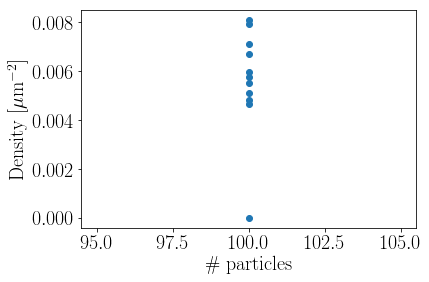

In [7]:
plt.plot(NumberOfParticlesArray,ProbsAtCenter*NumberOfParticlesArray/BoxX_um, 'o')
plt.ylabel('Density [$\mu$m$^{-2}$]')
plt.xlabel('\# particles')

In [ ]:
DO NOT FORGET FORCE FACTOR!!!!

# See orientations!!!!!!!!!

In [8]:
CurrentFolder

'C:/Users/M/PycharmProjects/Simulation/20190212_dblLineAsym2/With008CalibDragMult2'

In [16]:
ShortFilename = 'Sim_V_10p2_vel_3p6_Dt_0p1_C_1_Dr_0p1_NumPrtcls_1_dragFactorToPsv_2_coords.csv'
ShortFilename = 'Sim_V_10p2_vel_2p7_Dt_0p1_C_1_Dr_0p1_NumPrtcls_1_dragFactorToPsv_2_coords.csv'

# ShortFilename = 'Sim_V_10p2_vel_3p6_Dt_0p1_C_1p001_Dr_0p1_NumPrtcls_1_dragFactorToPsv_2_coords.csv'
# ShortFilename = 'Sim_V_10p2_vel_3p6_Dt_0p1_C_1p002_Dr_0p05_NumPrtcls_1_dragFactorToPsv_2_coords.csv'


FullPathTrajFilename = CurrentFolder + '//' + ShortFilename
# np.loadtxt(FullPathTrajFilename)
TrajArray = np.genfromtxt(FullPathTrajFilename, delimiter=',')

In [17]:
FullPathTrajFilename

'C:/Users/M/PycharmProjects/Simulation/20190212_dblLineAsym2/With008CalibDragMult2//Sim_V_10p2_vel_2p7_Dt_0p1_C_1_Dr_0p1_NumPrtcls_1_dragFactorToPsv_2_coords.csv'

In [18]:
VelocityCutOff = 8; 

In [19]:
velDiff = 2
x = TrajArray[:,1]
y = TrajArray[:,2]
dx = x[velDiff:] - x[:-velDiff]
dy = y[velDiff:] - y[:-velDiff]
BooleanToUse = (dx**2+dy**2) < velDiff * VelocityCutOff**2
x = TrajArray[velDiff:,1][BooleanToUse]
y = TrajArray[velDiff:,2][BooleanToUse]
p = TrajArray[velDiff:,0][BooleanToUse]
dx = dx[BooleanToUse]/velDiff
dy = dy[BooleanToUse]/velDiff

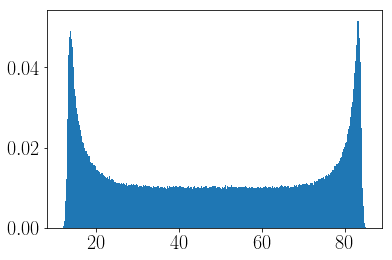

In [20]:
plt.hist(y, bins = 500, density = 'norm');

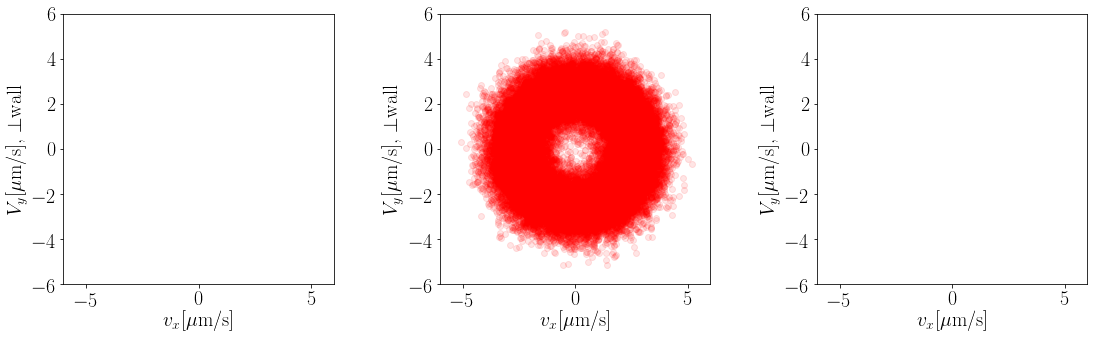

In [21]:
start_ums = [12, 51, 83] # 51,18,82
range_um = 2
fps = 5
FactorForUmPs = fps
fig, ax = plt.subplots(1, len(start_ums), figsize = [16,5])
for ind, start_um in enumerate(start_ums):
    alpha = 0.001
    if ((start_um<60) & (start_um>40)):
        alpha = 0.1
    ax[ind].scatter(FactorForUmPs*dx[(y>start_um) & (y<start_um+range_um)], 
                FactorForUmPs*dy[(y>start_um) & (y<start_um+range_um)], alpha = alpha, color= 'r')
    ax[ind].set_xlim([-6,6])
    ax[ind].set_ylim([-6,6])
    ax[ind].set_xlabel('$v_x[\mu$m/s]')
    ax[ind].set_ylabel('$V_y[\mu$m/s], $\\bot$wall')
    ax[ind].set_aspect('equal', adjustable='box')
fig.tight_layout()

In [22]:
BinSize_um = 0.25
# BinEdges = np.linspace(AllDistance.min(), AllDistance.max(), int(AllDistance.max()/BinSize_um))
BinEdges = np.linspace(y.min(), y.max(), int(y.max()/BinSize_um))

AvgXs = np.zeros(len(BinEdges)-1)
AvgYs = np.zeros(len(BinEdges)-1)
AvgVels = np.zeros(len(BinEdges)-1)
AvgThetas = np.zeros(len(BinEdges)-1)
AvgAbsYs, AvgAbsXs = np.zeros(len(BinEdges)-1), np.zeros(len(BinEdges)-1)
p_angles = np.mod(p, 2*np.pi)*180/np.pi
p_angles = - p_angles + 180
for ind in range(len(BinEdges)-1):
    start_um = BinEdges[ind]
    range_um = np.diff(BinEdges).mean()
    AvgYs[ind] = fps* dy[(y>=start_um) & (y<start_um+range_um)].mean()
    AvgThetas[ind] = p_angles[(y>=start_um) & (y<start_um+range_um)].mean()
    

    AvgVels[ind] = fps* (np.sqrt(dy[(y>=start_um) & (y<start_um+range_um)]**2 + 
                          dx[(y>=start_um) & (y<start_um+range_um)]**2)).mean()
    
    AvgVels[ind] = fps* np.sqrt((dy[(y>=start_um) & (y<start_um+range_um)]**2 + 
                          dx[(y>=start_um) & (y<start_um+range_um)]**2).mean())
    
    AvgXs[ind] = fps* dx[(y>=start_um) & (y<start_um+range_um)].mean()
    
    AvgAbsYs[ind] = fps* np.abs(dy[(y>=start_um) & (y<start_um+range_um)]).mean()
    AvgAbsXs[ind] = fps* np.abs(dx[(y>=start_um) & (y<start_um+range_um)]).mean()
    
# AvgAbsYs = AvgVels * np.abs(np.sin(AvgThetas)).mean()
# AvgAbsXs = AvgVels * np.abs(np.cos(AvgThetas)).mean()

(0, 100)

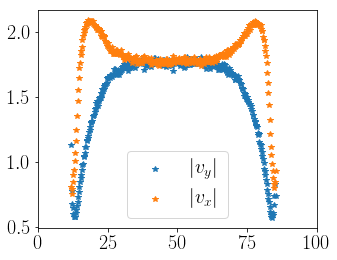

In [28]:
plt.figure(figsize=[5, 4])
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgAbsYs, '*')
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgAbsXs, '*')
plt.legend(['$|v_y|$','$|v_x|$'])
plt.xlim([0, 100])

(-0.1, 0.1)

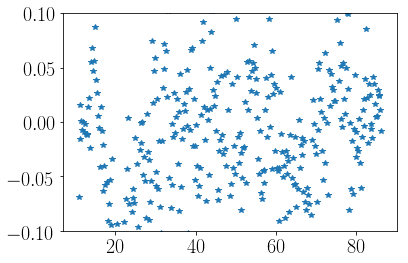

In [210]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgXs, '*')
plt.ylim([-0.1,0.1])

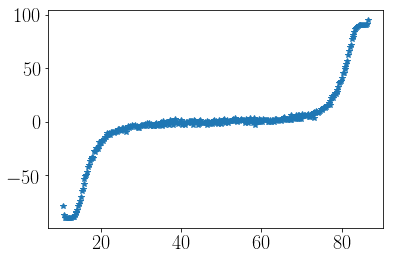

In [211]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgThetas, '*')
# plt.ylim([-0.1,0.1])

(0, 97)

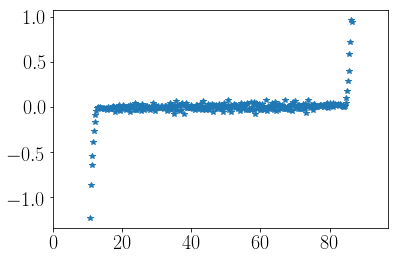

In [212]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgYs, '*')
plt.xlim([0,97])
# plt.ylim([-0.1, 0.1])

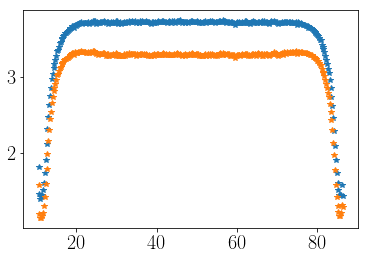

In [214]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgVels, '*')
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, np.sqrt(AvgAbsYs**2 + AvgAbsXs**2), '*')

# plt.ylim([-0.1,0.1])

# see Movie

In [136]:
filelistPDF

['C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint\\Sim_V_7_vel_0p1_Dt_0p1_Dr_0p1_NumPrtcls_1000_dragFactorToPsv_1_PDfunc.csv',
 'C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint\\Sim_V_7_vel_0p1_Dt_0p1_Dr_0p1_NumPrtcls_100_dragFactorToPsv_1_PDfunc.csv',
 'C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint\\Sim_V_7_vel_0p1_Dt_0p1_Dr_0p1_NumPrtcls_2000_dragFactorToPsv_1_PDfunc.csv',
 'C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint\\Sim_V_7_vel_0p1_Dt_0p1_Dr_0p1_NumPrtcls_500_dragFactorToPsv_1_PDfunc.csv',
 'C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint\\Sim_V_7_vel_0p1_Dt_0p1_Dr_0p1_NumPrtcls_50_dragFactorToPsv_1_PDfunc.csv',
 'C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint\\Sim_V_7_vel_1_Dt_0p1_Dr_0p1_NumPrtcls_1000_dragFactorToPsv_1_PDfunc.csv',
 'C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint\\Sim_V_7_vel_1_Dt_0p1_Dr_0p1_NumPrtcls_100_dragFactorToPsv_1_

In [147]:

movieName='Sim_V_7_vel_1_Dt_0p1_Dr_0p1_NumPrtcls_2000_dragFactorToPsv_1_coords.csv'
subFolder

'SimulationWeakTorqueSymPPint'

In [148]:
CurrentFolder

'C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint'

In [149]:
coords=np.genfromtxt(CurrentFolder+'/'+movieName, delimiter=',')


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 330.98it/s]

min x: 0.10411292202208415 min y: 11.971011437833948
max x: 199.92873673551787 max y: 88.49454597454266


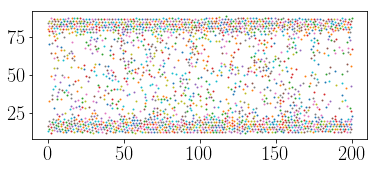

In [150]:
if 1:
    coords=np.genfromtxt(subFolder+'/'+movieName, delimiter=',')
    # Checking trajectories, last 50 steps
    fig, ax = plt.subplots()
    ParticlesToPlot=range(NumberOfParticles);
    maxy,maxx=0,100
    miny,minx=100,100
    for particleNum in tqdm(ParticlesToPlot):
        x=coords[-1:,3*particleNum+1]
        y=coords[-1:,3*particleNum+2]
        if y.max()>maxy:
            maxy=y.max() ;
        if y.min()<miny:
            miny=y.min() ;
        if x.max()>maxx:
            maxx=x.max() ;
        if x.min()<minx:
            minx=x.min() ;
        ax.plot(x,y,'8',markersize=1)
    # ax1.axis('equal')
    # ax1.set_xlim([0,BoxX])
    # ax1.set_ylim([0,BoxY])
    ax.set_aspect('equal')
    print('min x:', str(minx), 'min y:', str(miny))
    print('max x:', str(maxx), 'max y:', str(maxy))

In [151]:
DirName=CurrentFolder+'/'+movieName[:-29]+'/'
os.mkdir(DirName) # creating new folder
DirName

'C:/Users/M/PycharmProjects/Simulation/SimulationWeakTorqueSymPPint/Sim_V_7_vel_1_Dt_0p1_Dr_0p1_NumPrtcls_2000/'

In [152]:
len(coords)

800

In [153]:
BoxX_um=200
ChannelLength_um=100
FrameIntervalForMovie=1; 
img=np.zeros([ChannelLength_um,BoxX_um])
MovieCoords=coords[::FrameIntervalForMovie,:]

In [154]:
def MakeFrameIndexForAnimation(FrameNum,MaximalFrameNum):
    IndexRequiredLength=len(str(MaximalFrameNum));
    LengthOfCurrentString=len(str(FrameNum))
    NumberOfZerosToAdd=IndexRequiredLength-LengthOfCurrentString;
    NewIndexForCurrentFrame='0'*NumberOfZerosToAdd+str(FrameNum)
    return NewIndexForCurrentFrame 
def format_func(value, tick_number):
    return str(int(value))

In [155]:
for i in tqdm(range(len(MovieCoords))):  # this list is using the cropped enumeration, starting at 0 for the cropped. 
    plt.ioff()
    fig, ax = plt.subplots()
    NewIndexForCurrentFrame=MakeFrameIndexForAnimation(i,len(MovieCoords)) # just an index to save the file on HD
    ax.scatter(MovieCoords[i,1::3], MovieCoords[i,2::3], marker ='.', s=1, color='k')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    pathname=DirName+movieName[:-11]+'_'+NewIndexForCurrentFrame+'.png'
    ax.set_xlim([0,BoxX_um])
    ax.set_ylim([0,ChannelLength_um])
    fig.savefig(pathname, dpi=200)
    # fig.clf()
    plt.close(fig)


 31%|████████████████████████▊                                                       | 248/800 [00:24<00:54, 10.15it/s]


 62%|█████████████████████████████████████████████████▌                              | 496/800 [00:49<00:29, 10.34it/s]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 747/800 [01:13<00:05, 10.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:19<00:00, 11.13it/s]

In [156]:
# To create a movie from the jpeg's
fps=1; 
temp=DirName
DirName=temp
DirNameForImageio=temp
filenamesForImageio = [f for f in os.listdir(DirName) if f.endswith('.png')]
import imageio
# DirNameForImageio='C:/Users/M/Dropbox/MicroOsmotic/Python/'+DirName
MovieFileNameImageIO=('/'+movieName[:-4]+'.mp4')
DirNameForImageio=DirName
with imageio.get_writer(DirNameForImageio+'\\'+MovieFileNameImageIO, mode='I', fps=fps) as writer:
    for ImagIOfilename in tqdm(filenamesForImageio):
        image = imageio.imread(DirNameForImageio+'\\'+ImagIOfilename)
        writer.append_data(image)
writer.close()


 48%|█████████████████████████████████████                                         | 380/800 [3:00:15<00:21, 19.11it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [4:03:28<00:00, 18.26s/it]